In [1]:
import numpy as np
import pandas as pd
from scipy.stats import itemfreq

import matplotlib.pyplot as plt

from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge

from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, train_test_split

% matplotlib inline

In [2]:
# reading data
data_path = './data/'

predicted_demand = pd.read_csv('./predicted_demand.csv')
# predicted_demand = pd.read_csv(data_path+'train/historical_demand.csv')
delivery_cost = pd.read_csv(data_path+'train/delivery_cost.csv')
production_capacity = pd.read_csv(data_path+'train/production_capacity.csv')

In [3]:
regions = np.unique(predicted_demand['Region'])
products = np.unique(predicted_demand['Product_ID'])

['P1' 'P10' 'P11' 'P12' 'P13' 'P14' 'P15' 'P16' 'P17' 'P18' 'P19' 'P2'
 'P20' 'P21' 'P22' 'P23' 'P24' 'P25' 'P26' 'P27' 'P28' 'P29' 'P3' 'P30'
 'P31' 'P32' 'P33' 'P34' 'P35' 'P36' 'P37' 'P38' 'P39' 'P4' 'P40' 'P41'
 'P42' 'P43' 'P44' 'P45' 'P46' 'P47' 'P48' 'P49' 'P5' 'P50' 'P51' 'P52'
 'P53' 'P54' 'P55' 'P56' 'P57' 'P58' 'P59' 'P6' 'P60' 'P61' 'P62' 'P63'
 'P64' 'P65' 'P66' 'P67' 'P68' 'P69' 'P7' 'P70' 'P71' 'P72' 'P73' 'P74'
 'P75' 'P76' 'P77' 'P78' 'P79' 'P8' 'P80' 'P81' 'P9']


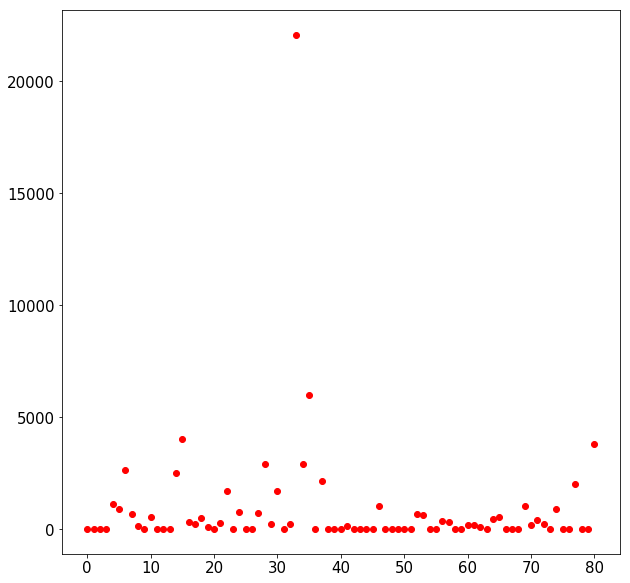

In [15]:
#product demand
products
prod_freq = [0] * len(products)
indices = list(range(len(products)))
indices
for i in range(len(products)):
    freq = predicted_demand.loc[(predicted_demand['Product_ID'] == products[i])]
    prod_freq[i] = freq['Demand'].sum()
print(products)
plt.figure(figsize=(10,10))
plt.rc('font', size=15)
# print(predicted_demand.loc[(predicted_demand['Product_ID'].isin(products[:10]))])
# plt.hist(predicted_demand.loc[(predicted_demand['Product_ID'].isin(products[:10]))]['Product_ID'])
width = indices[1] - indices[0]
plt.plot(indices , prod_freq, 'ro')
plt.show()

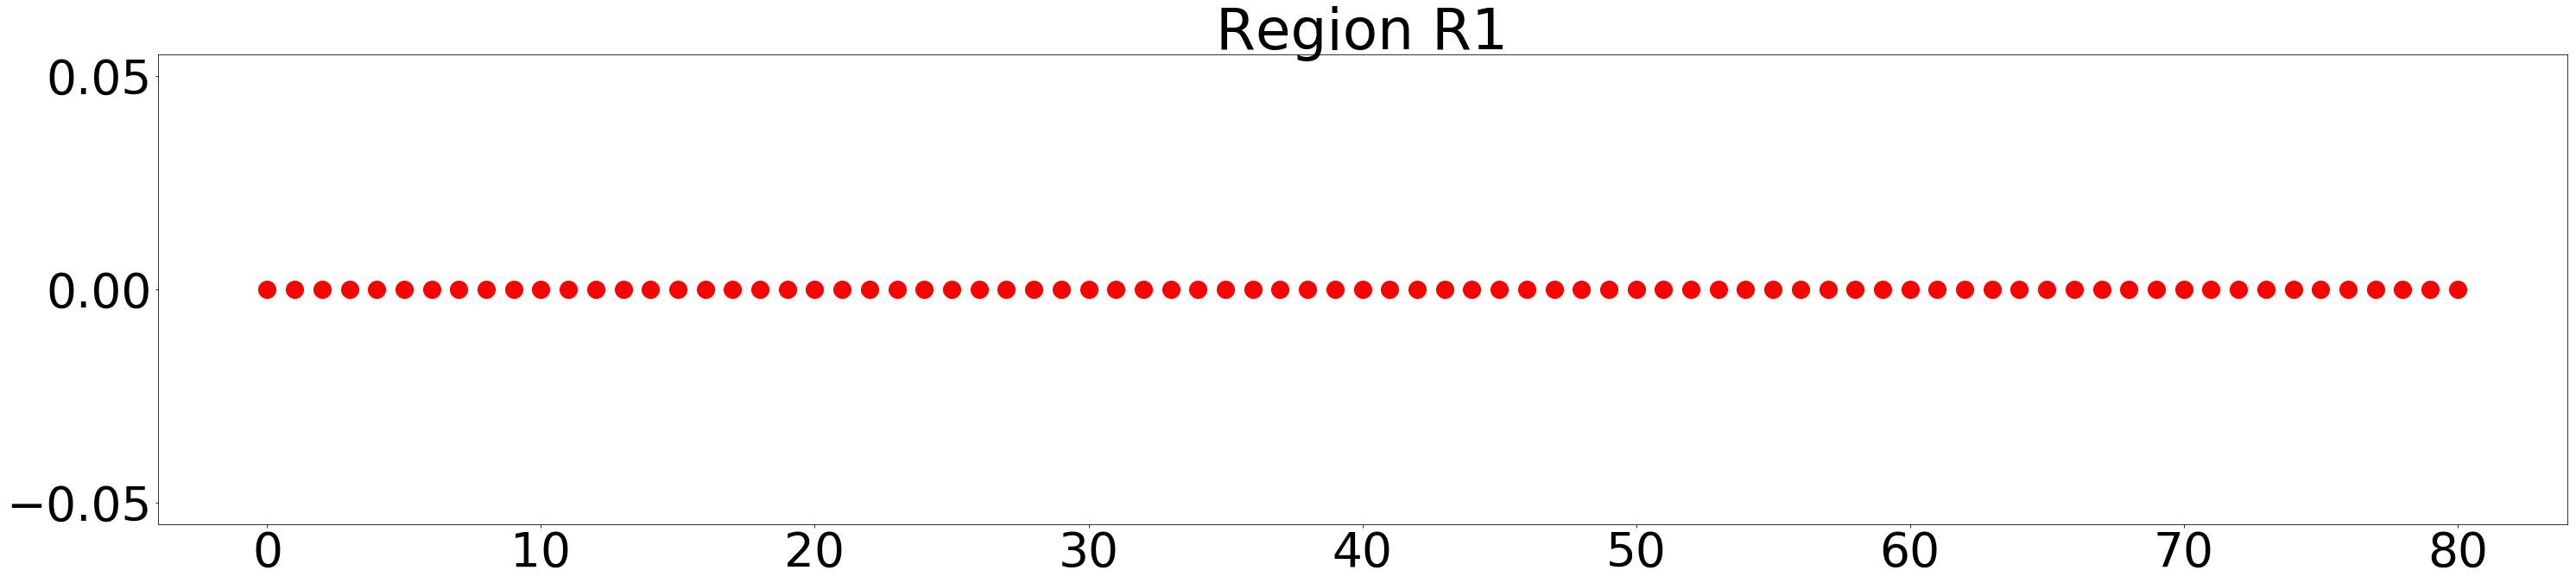

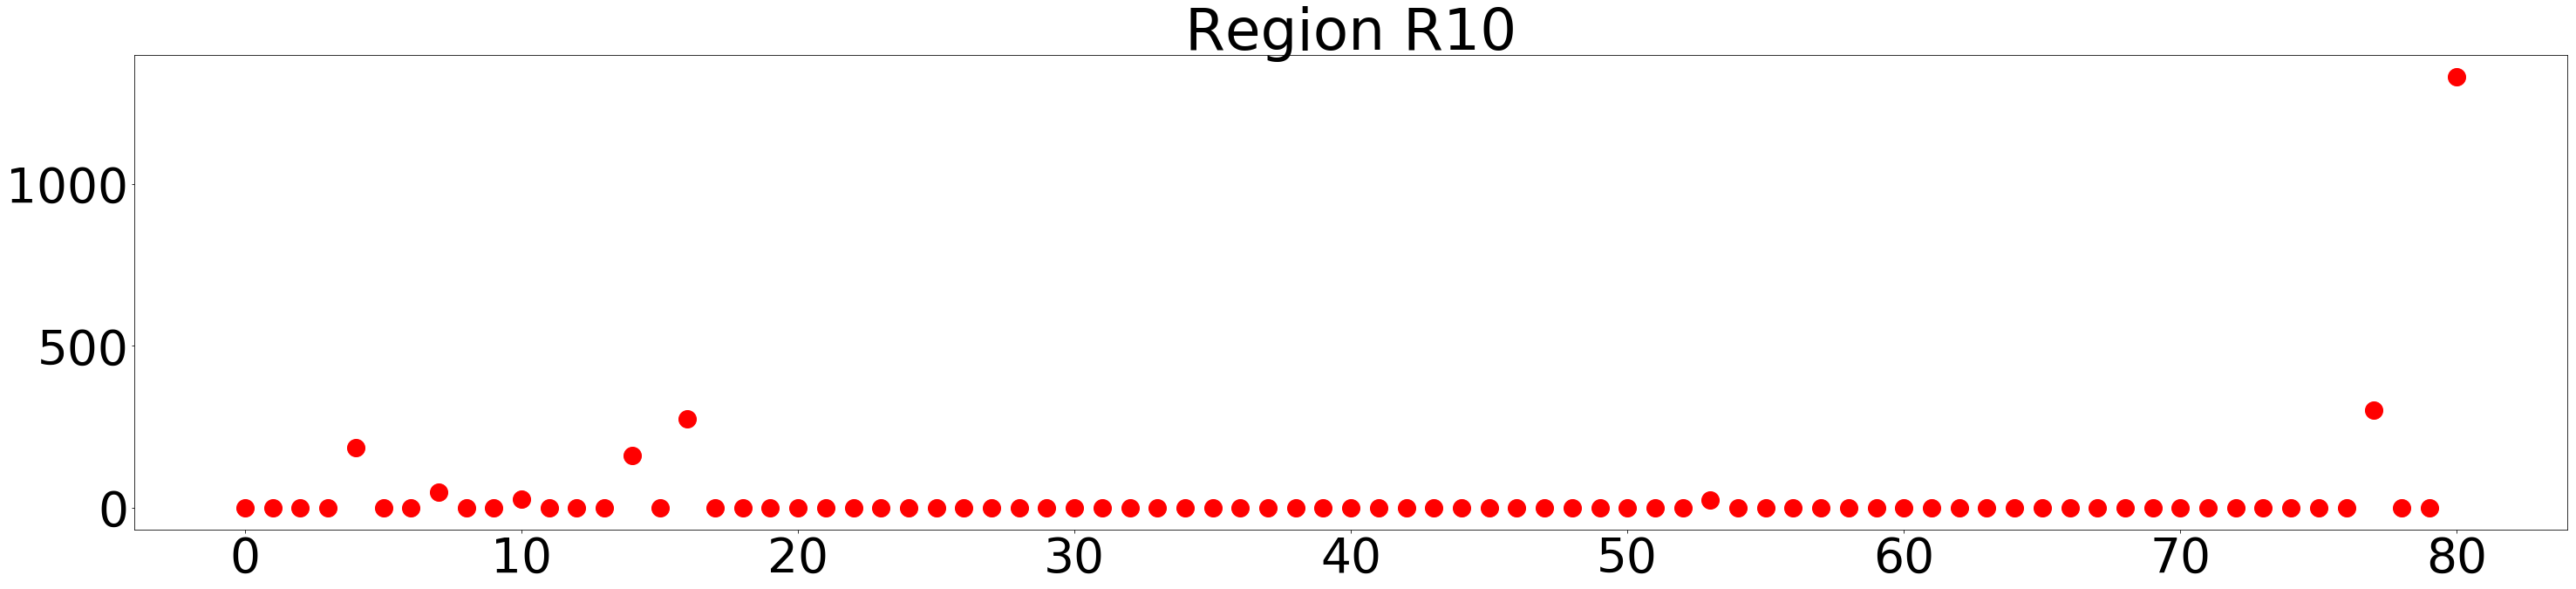

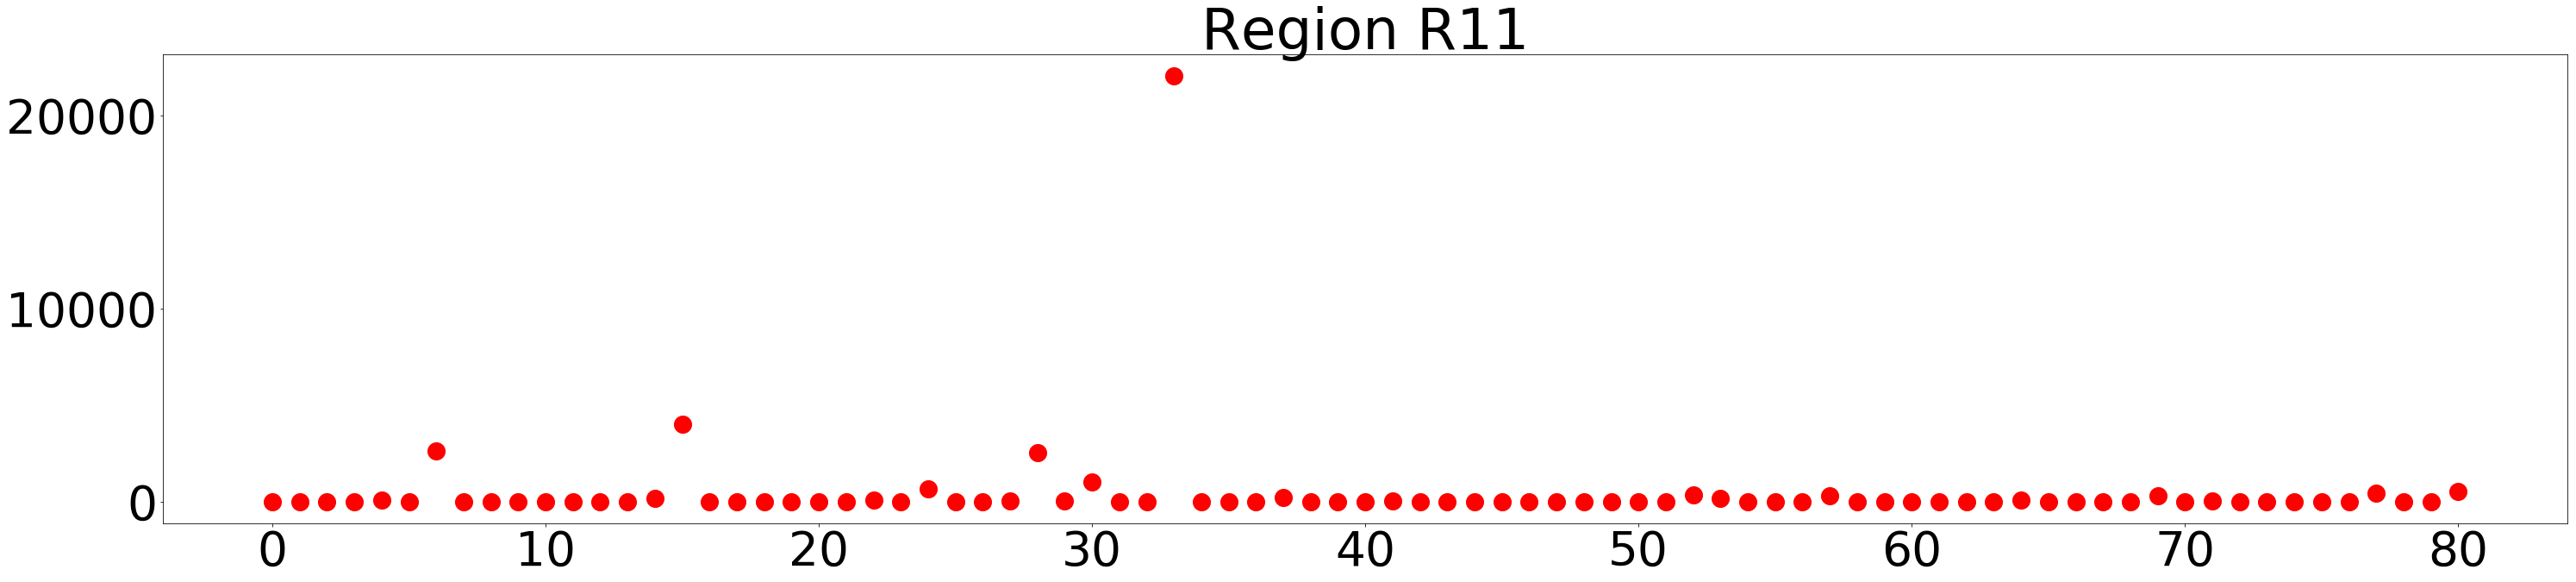

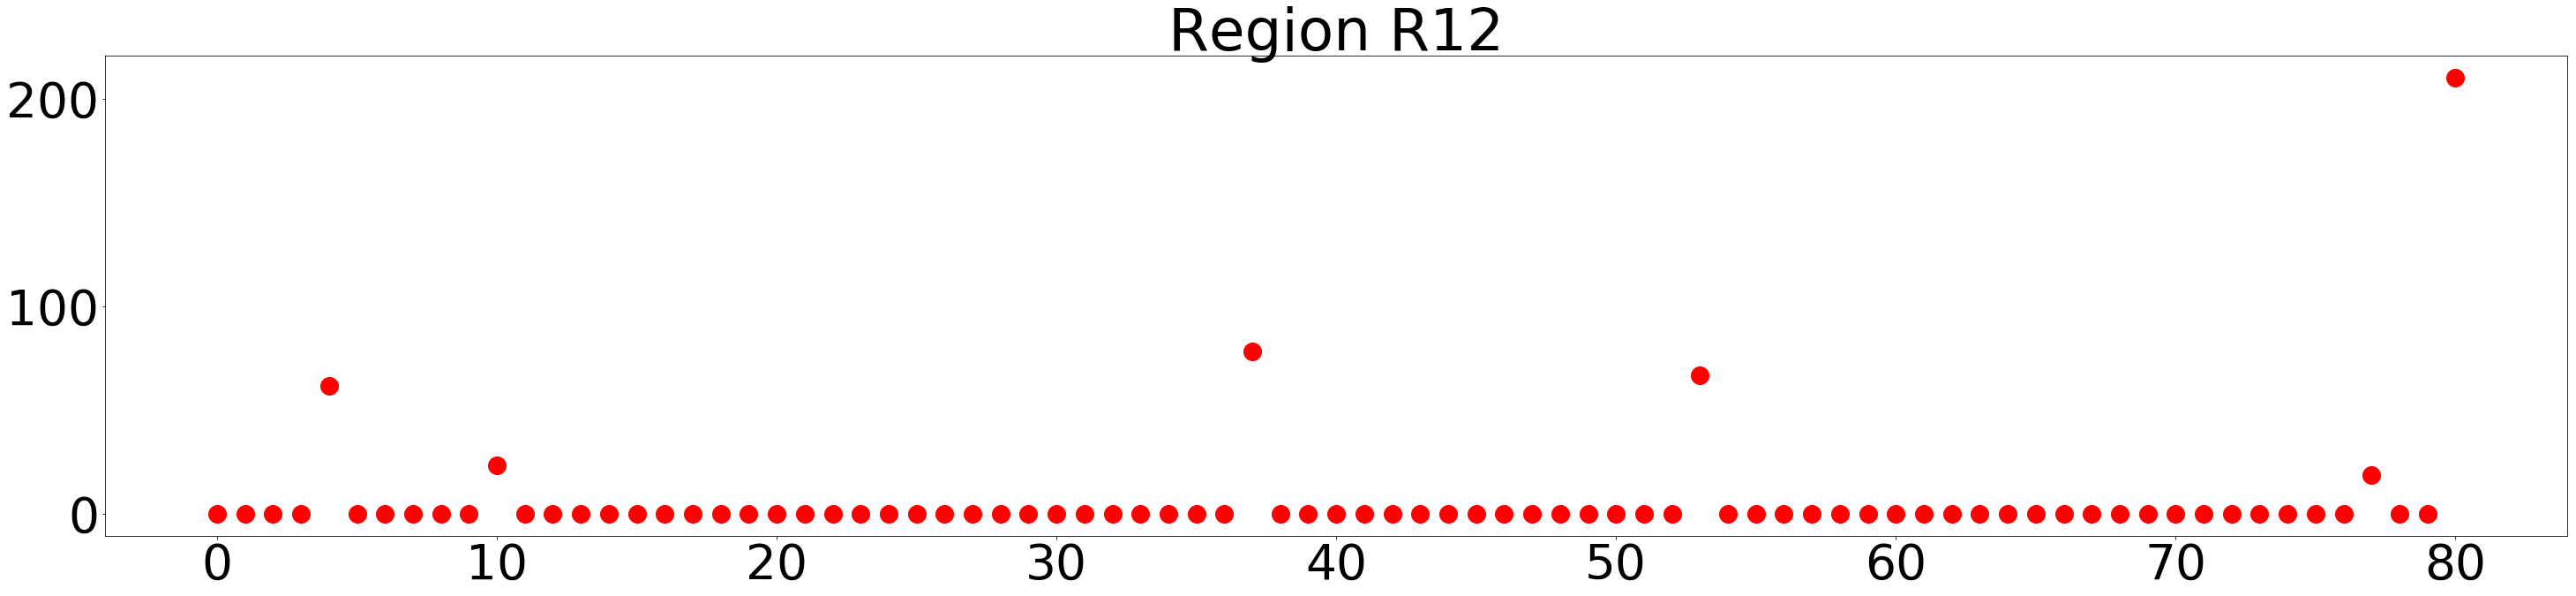

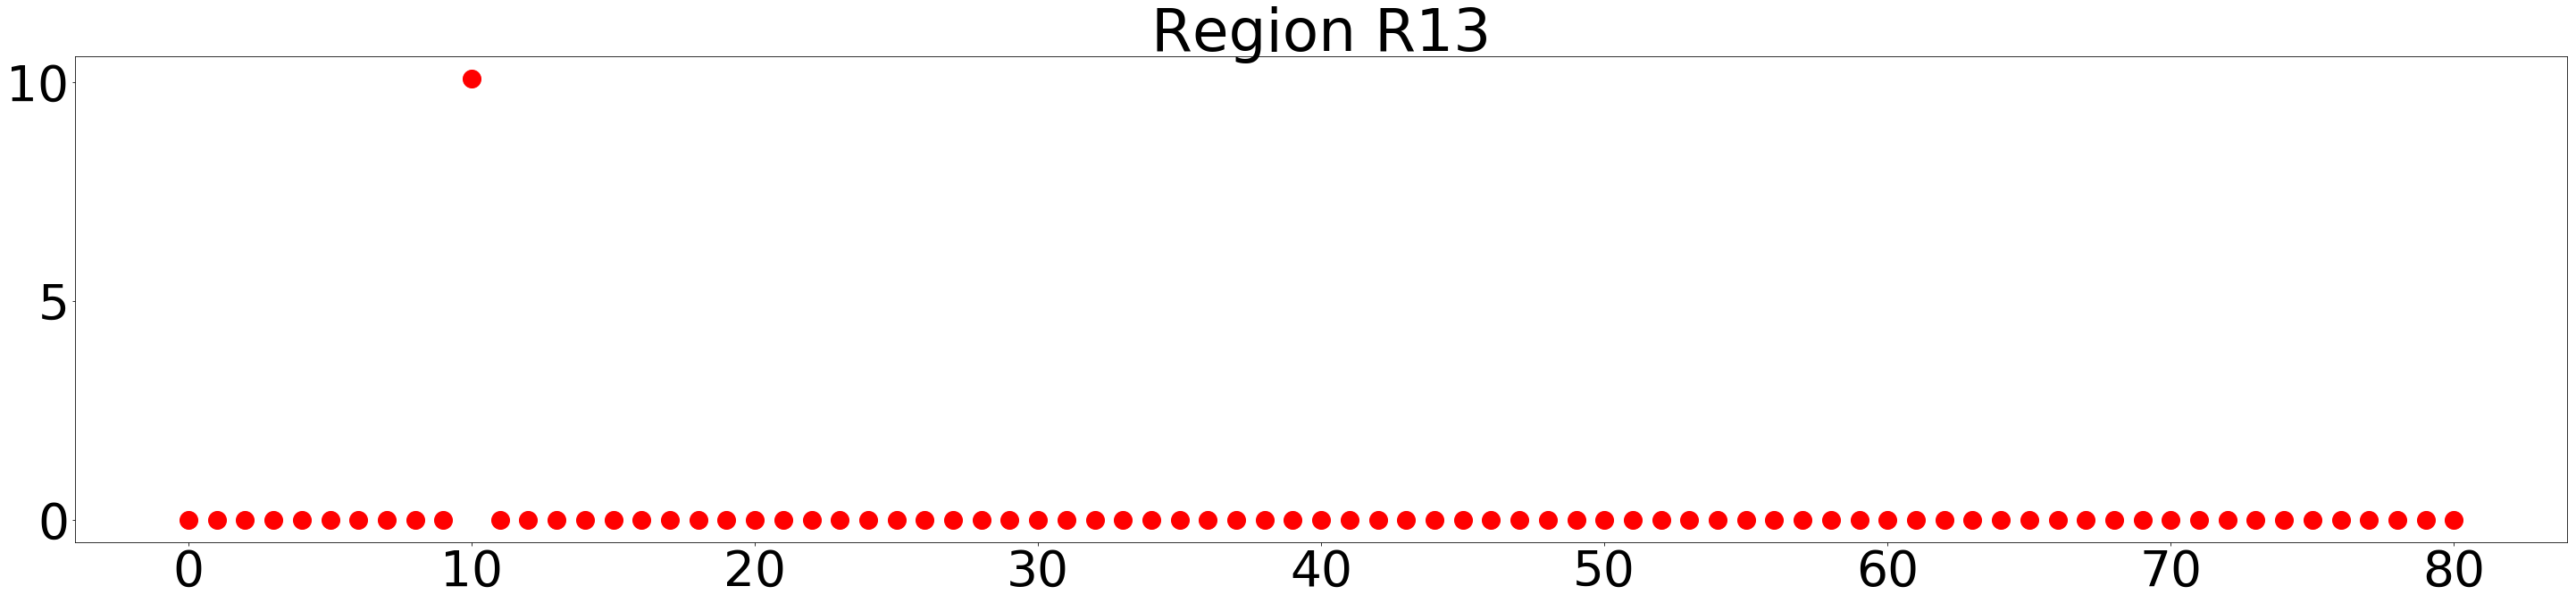

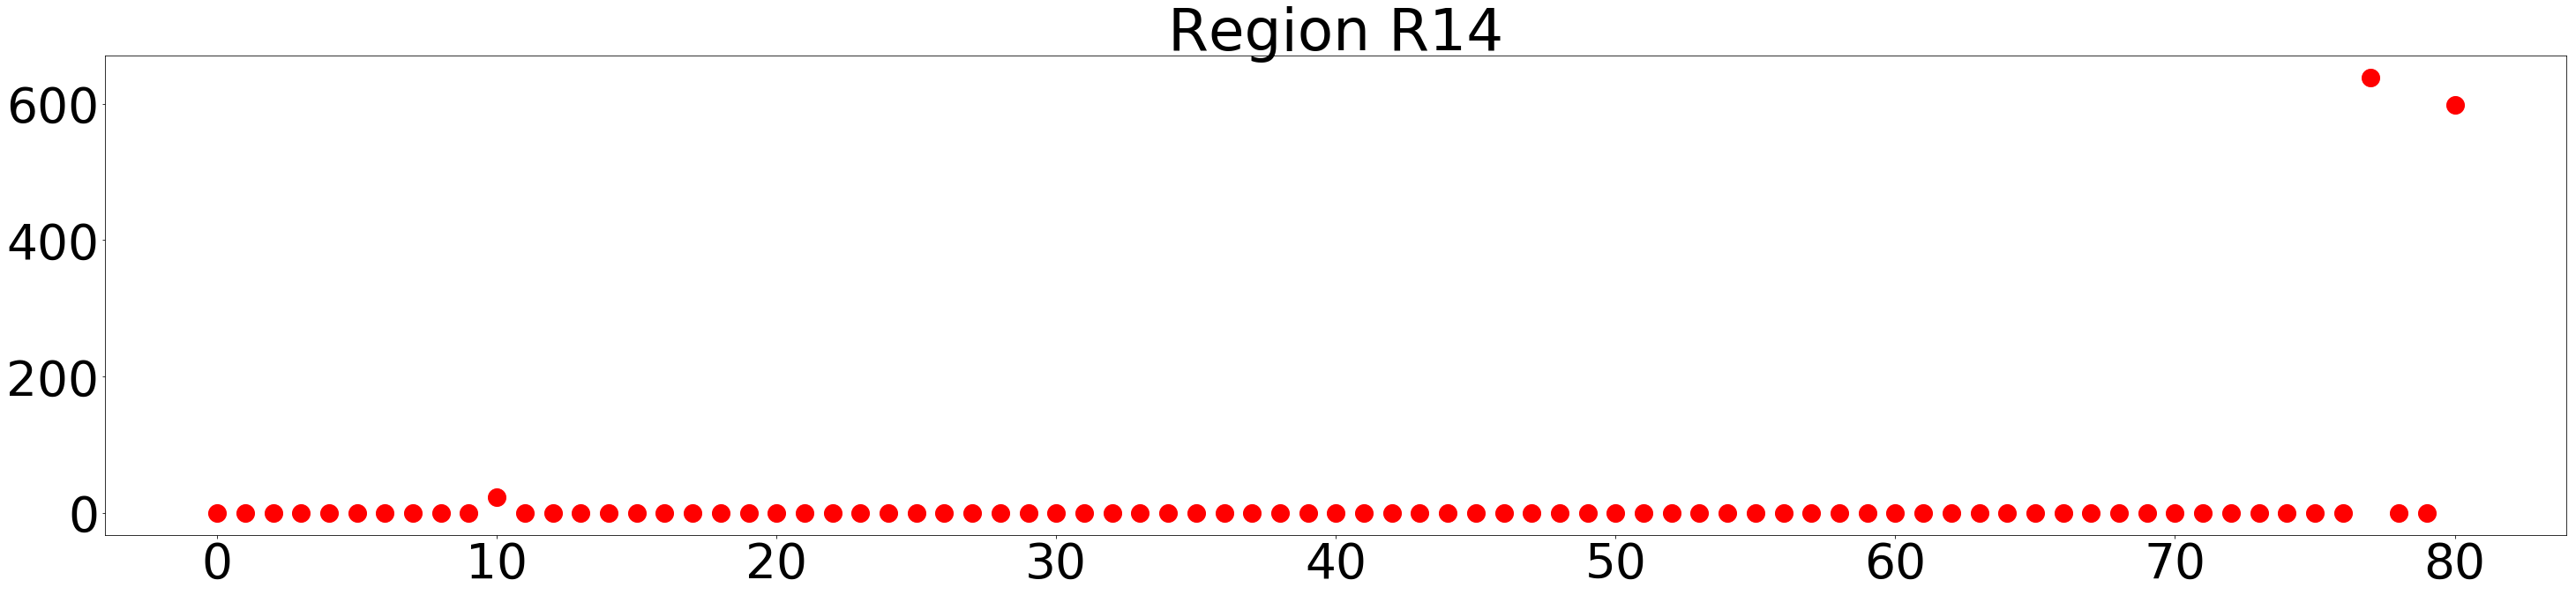

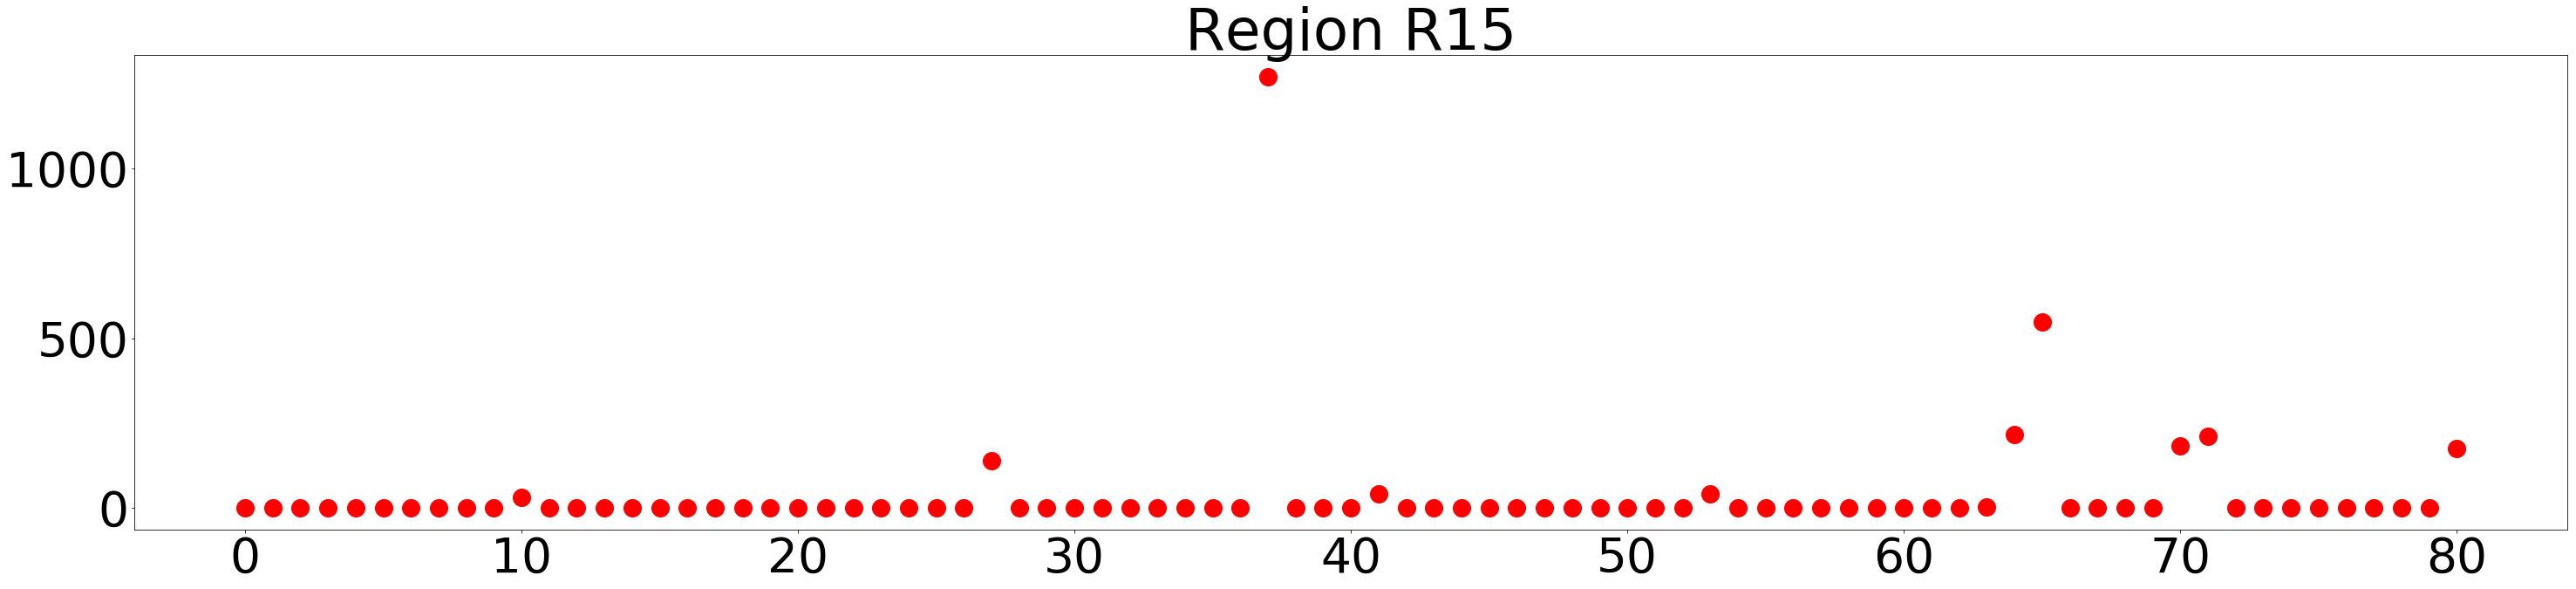

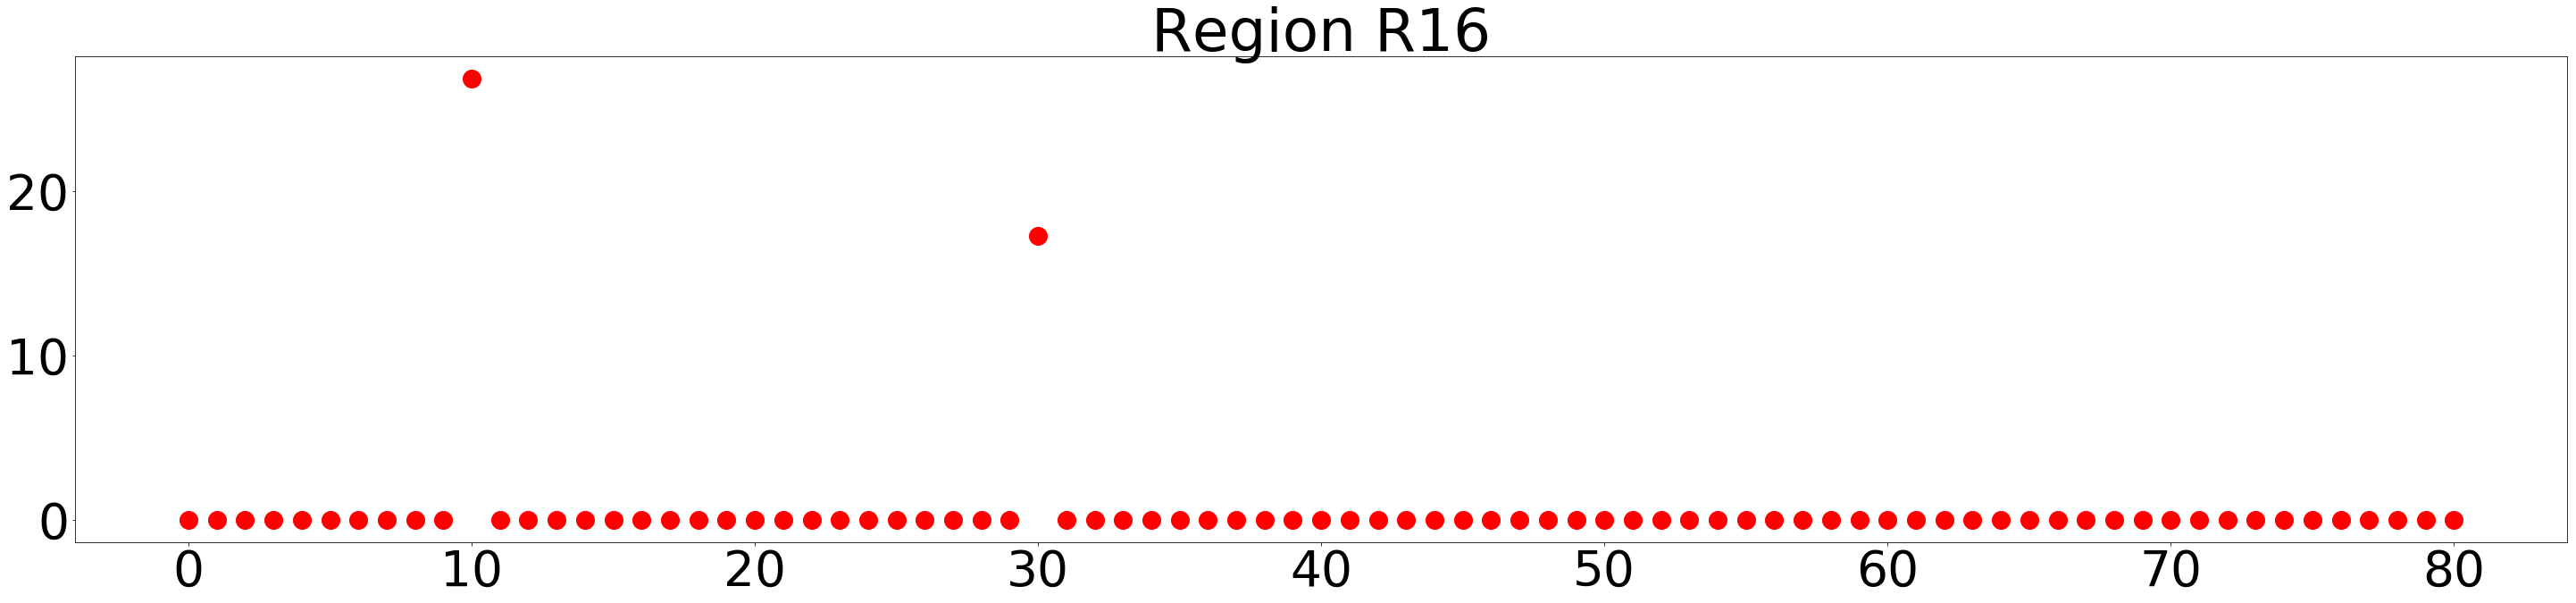

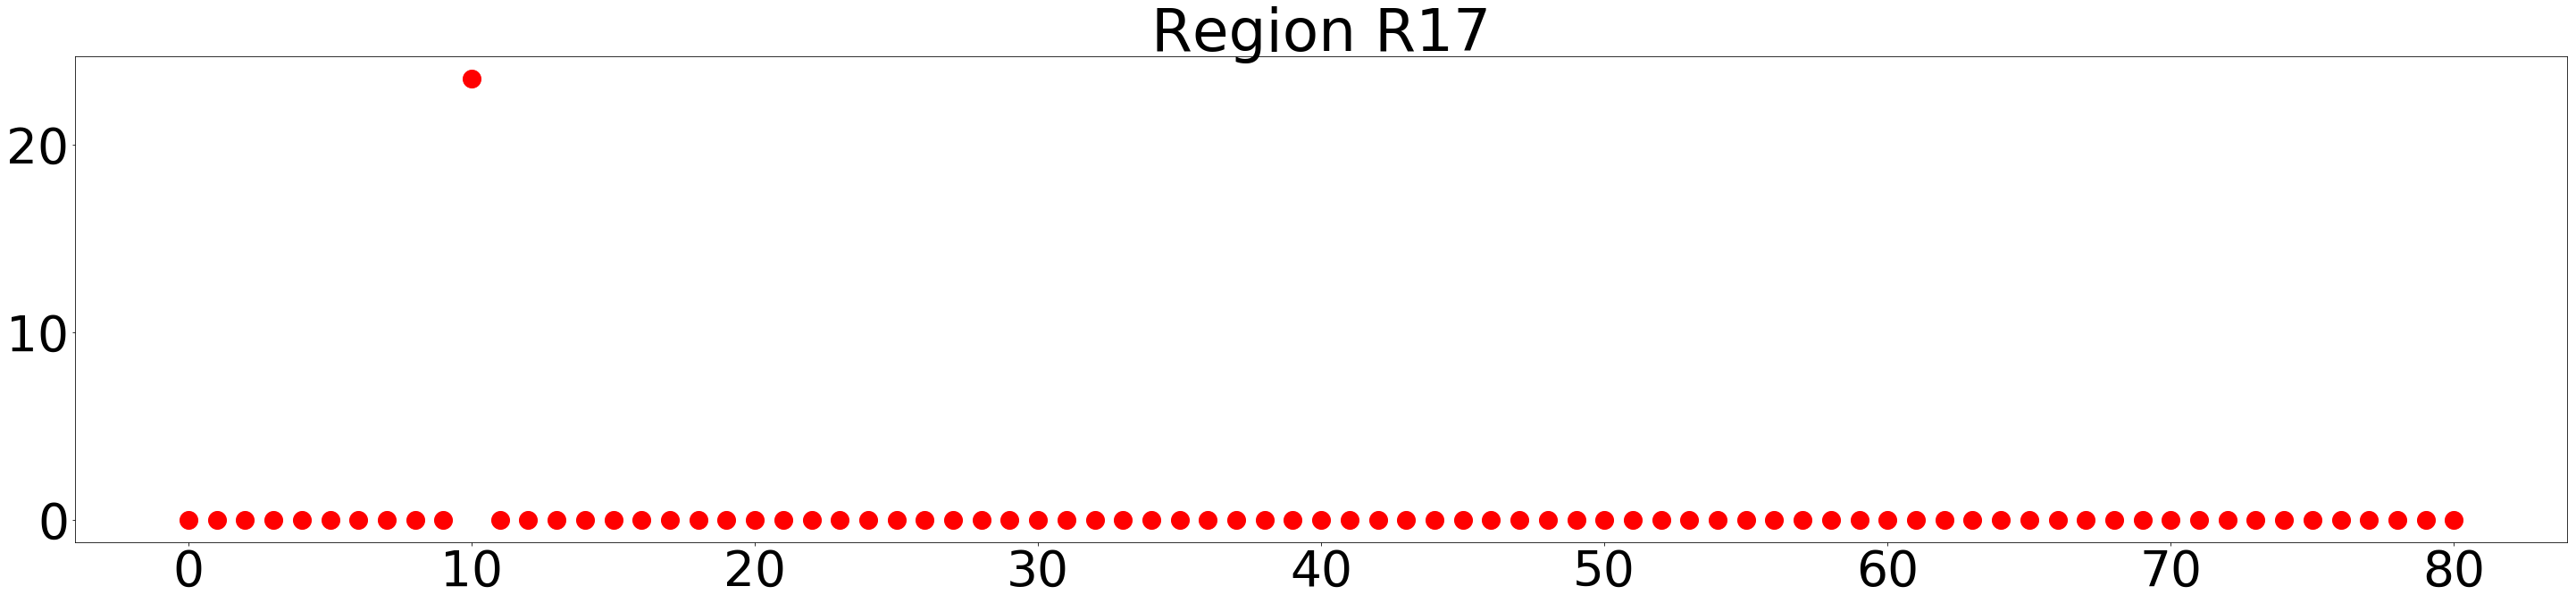

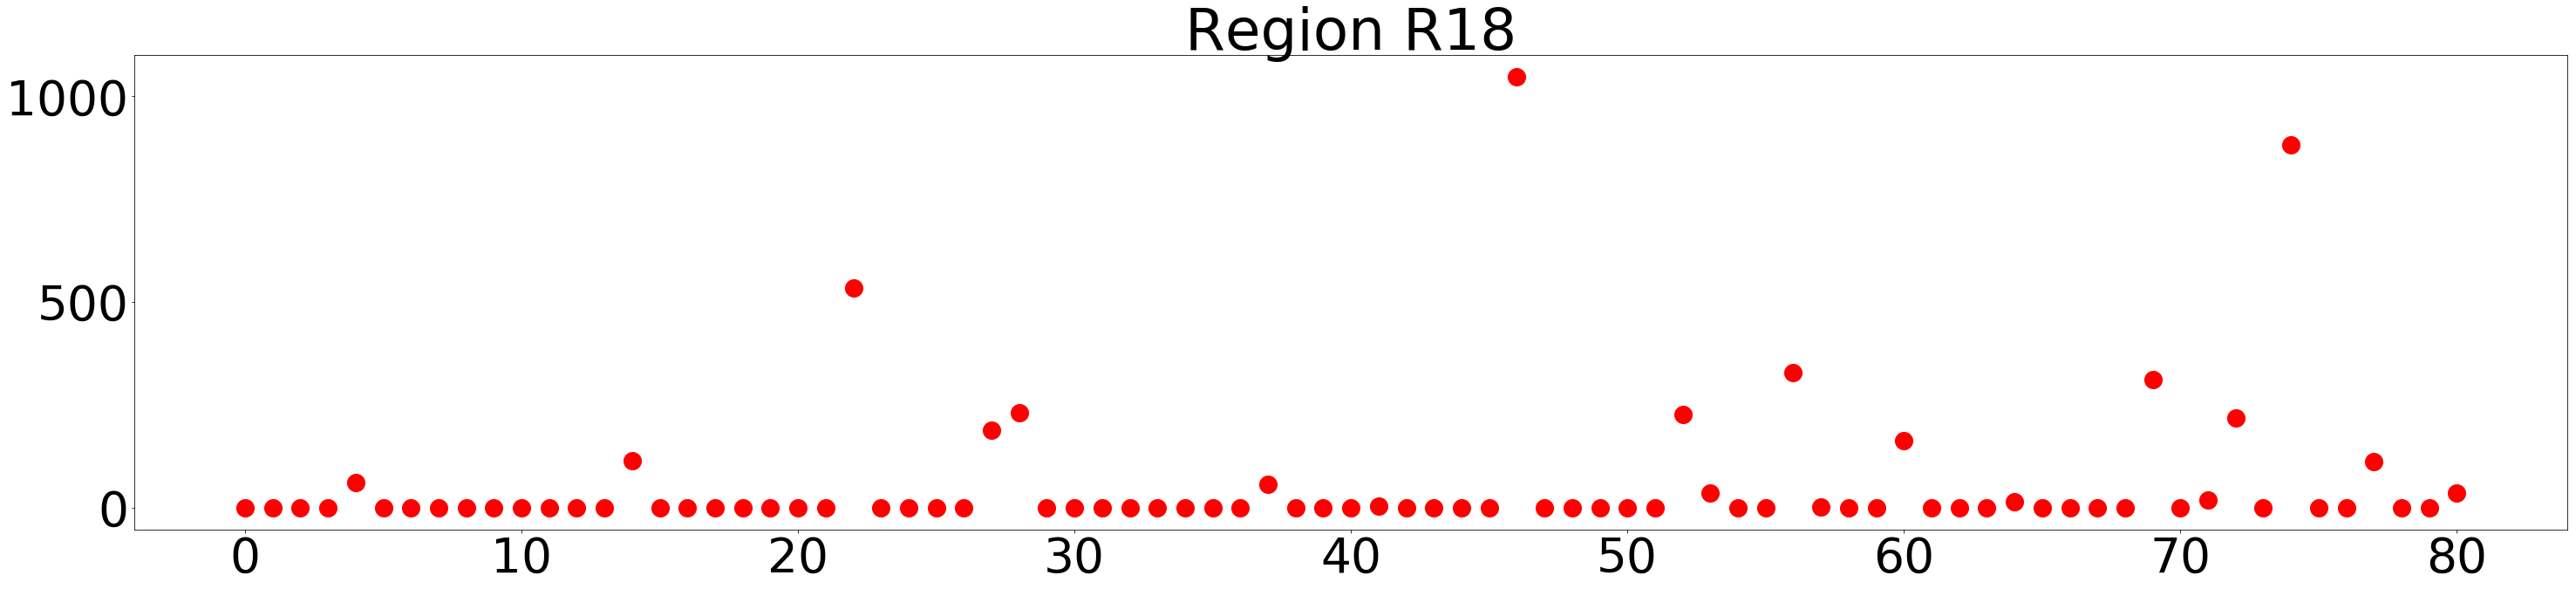

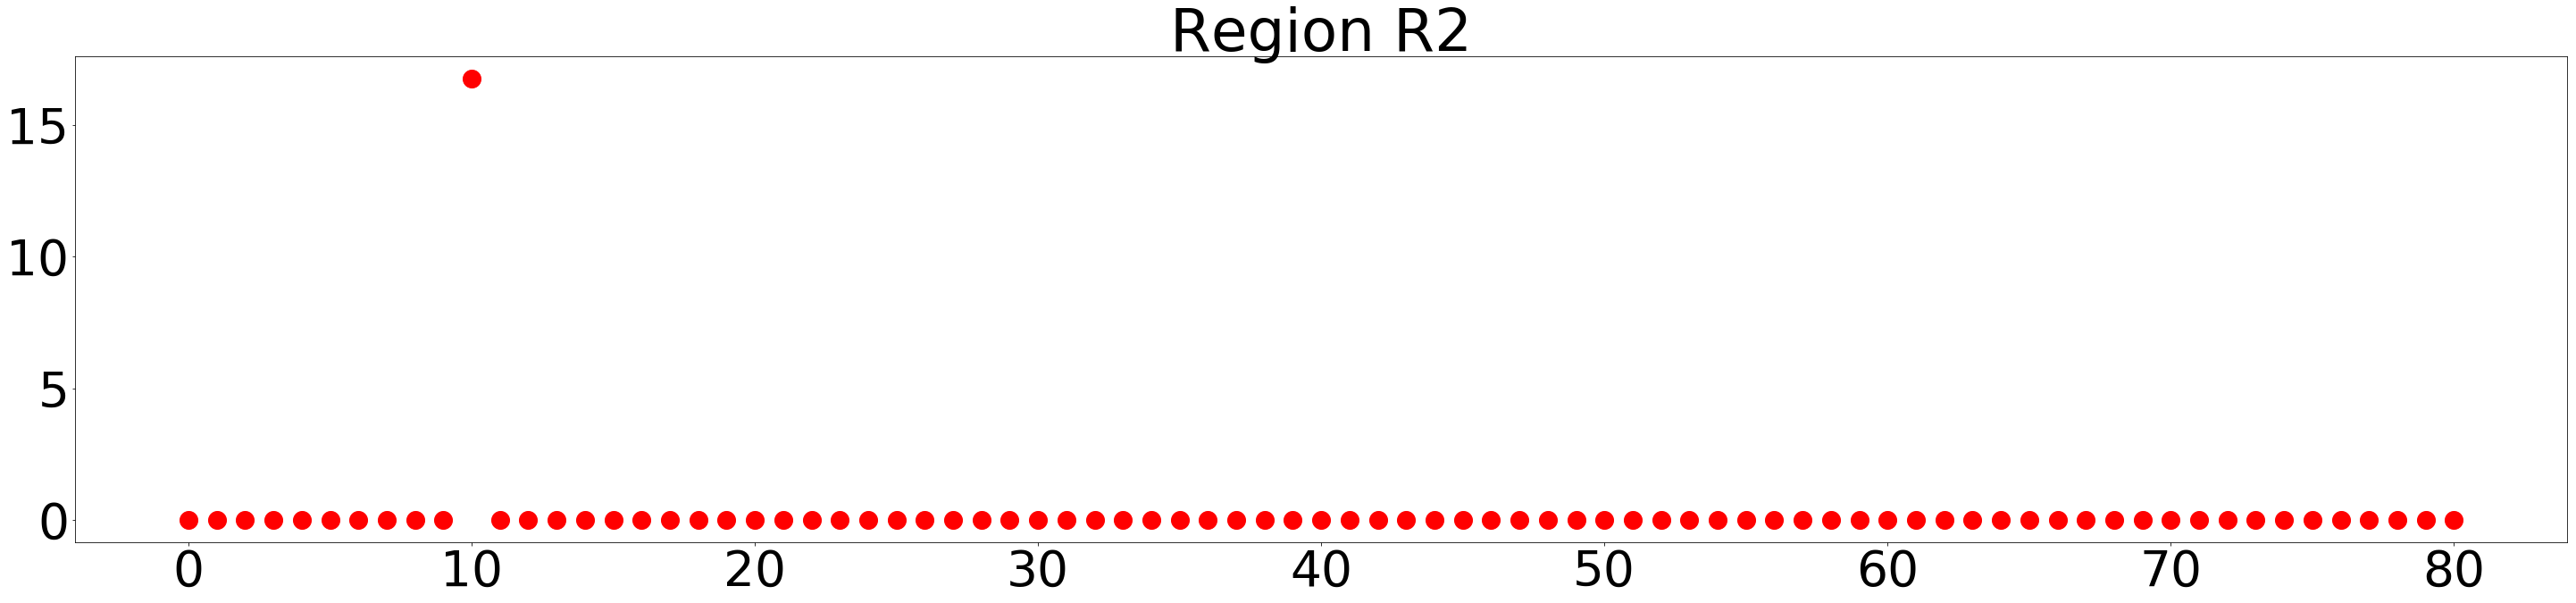

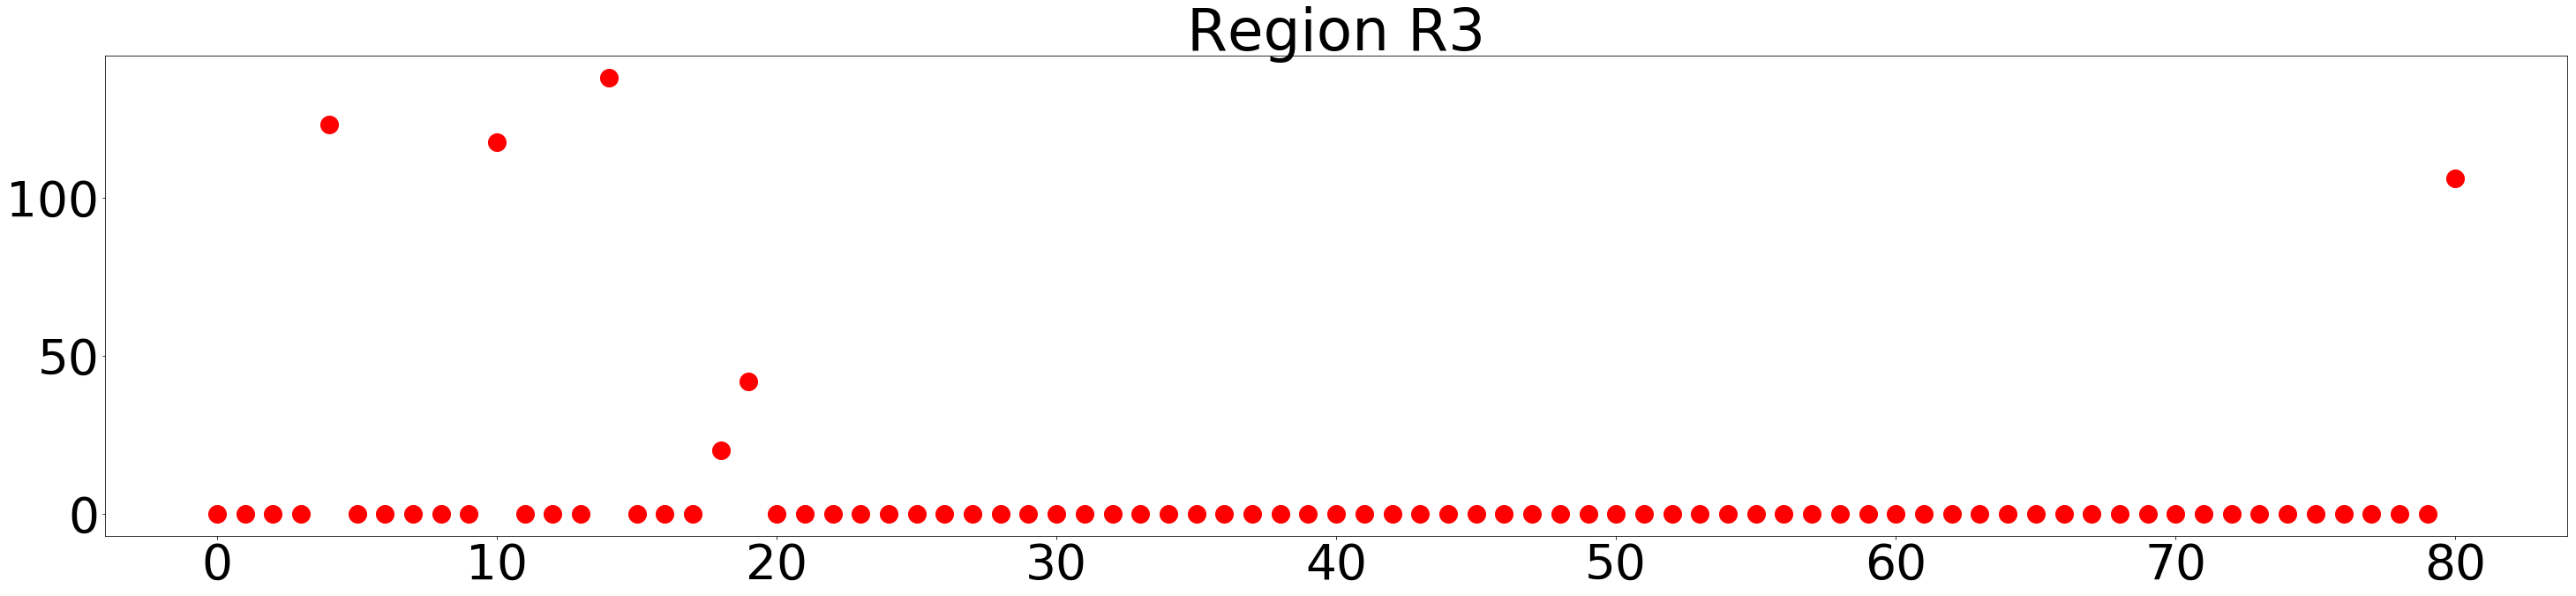

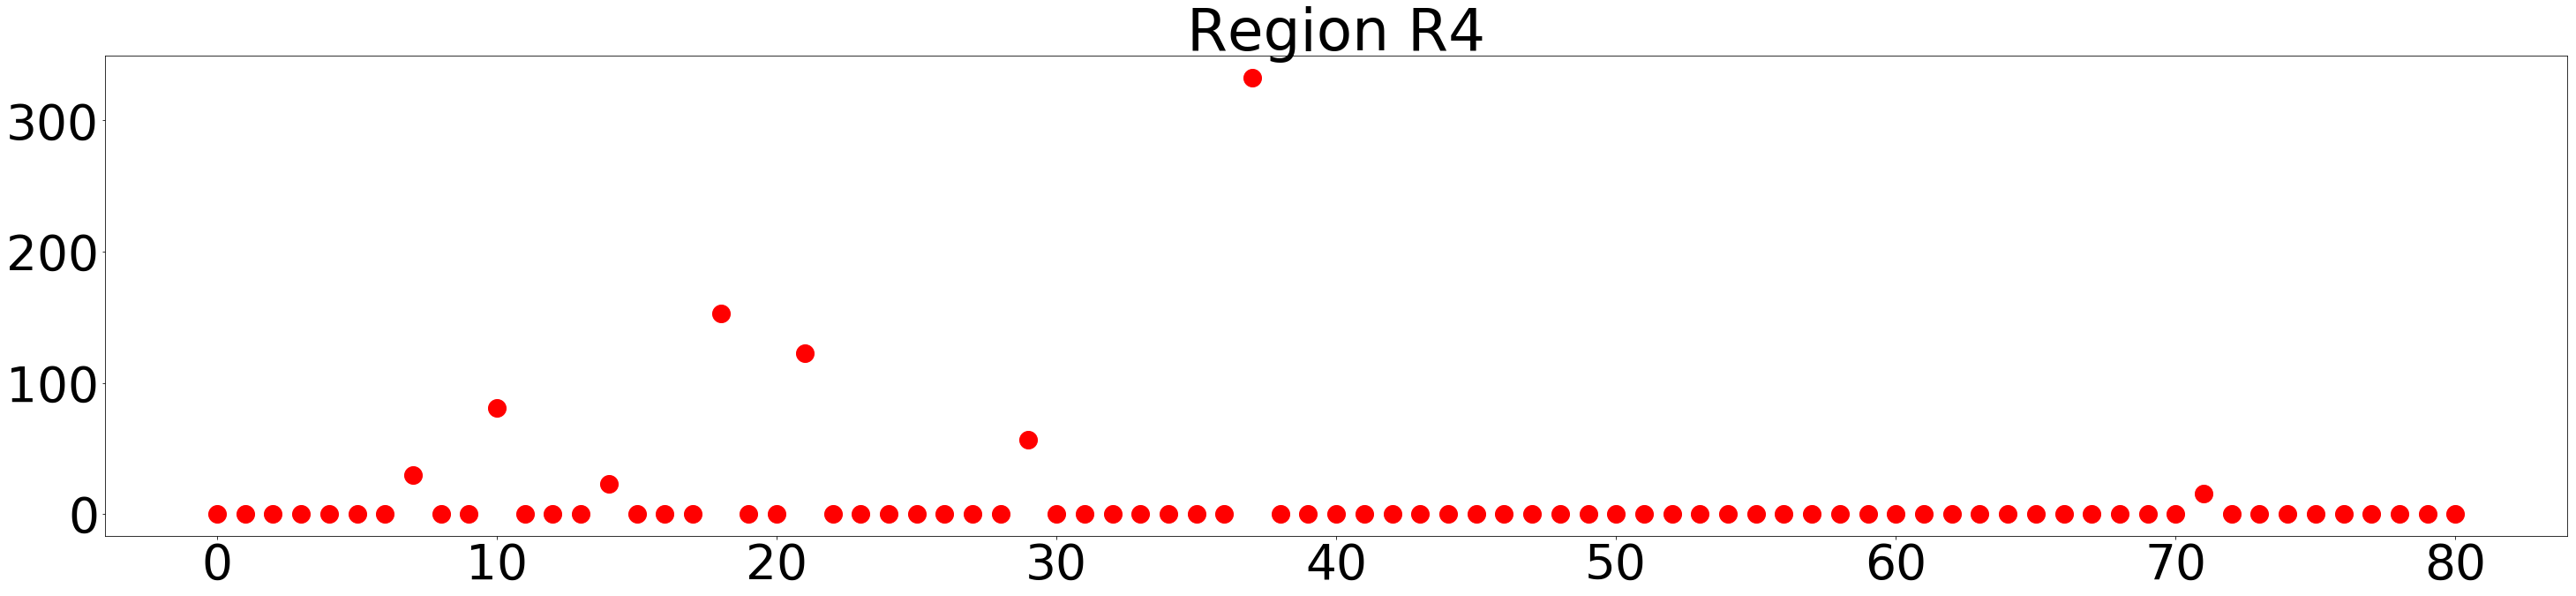

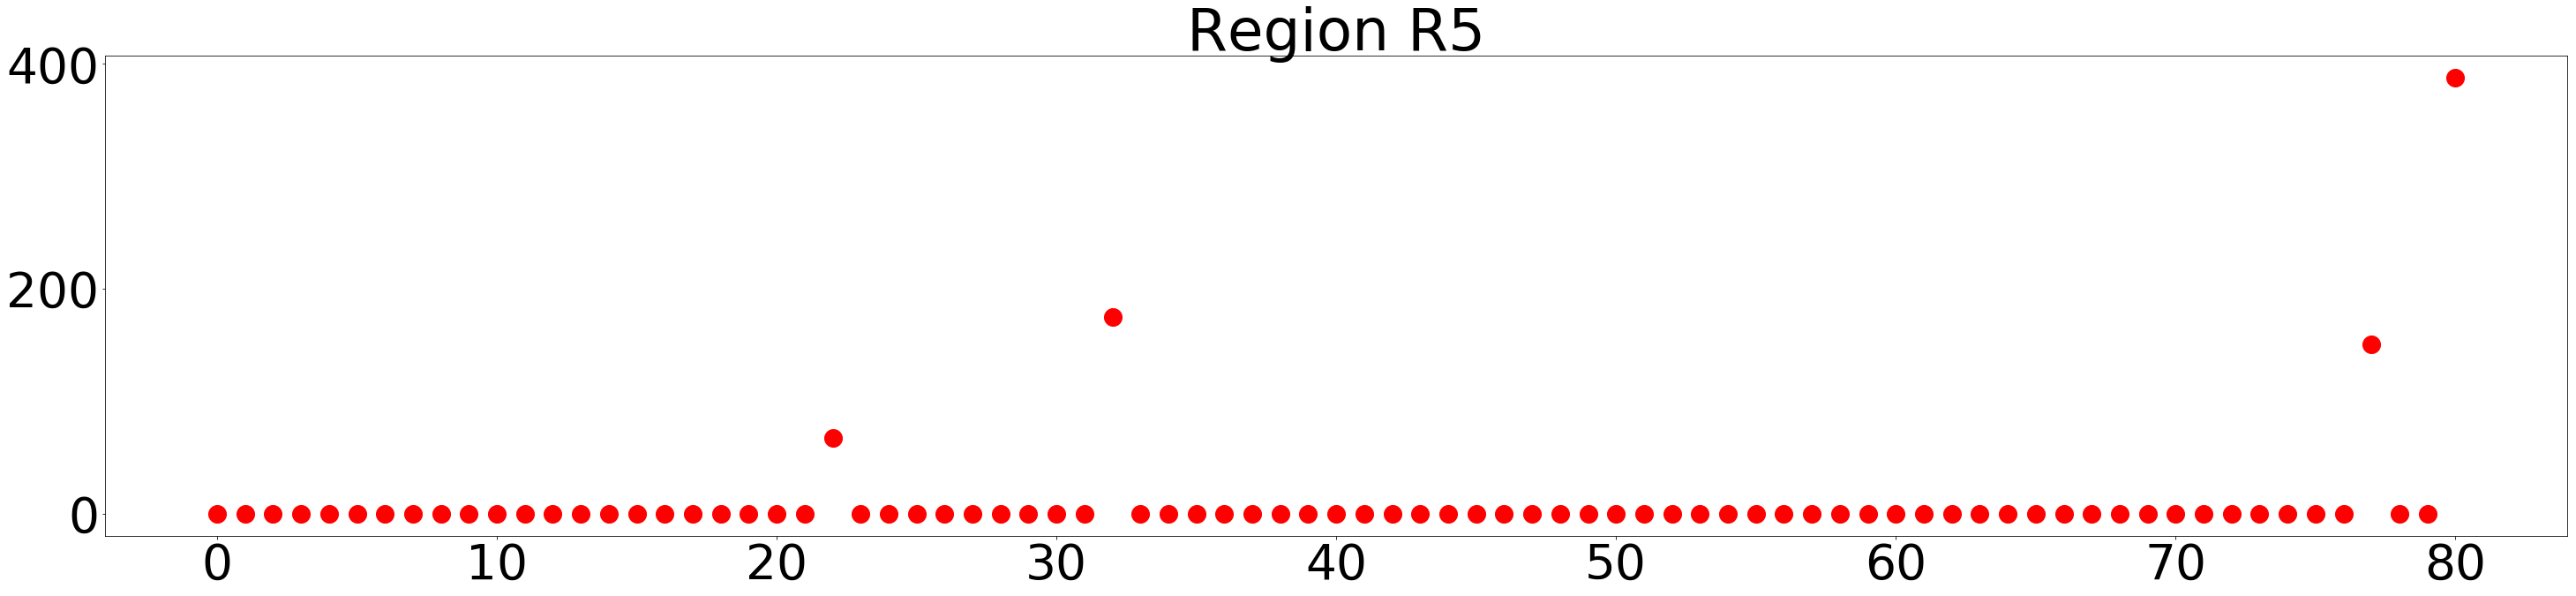

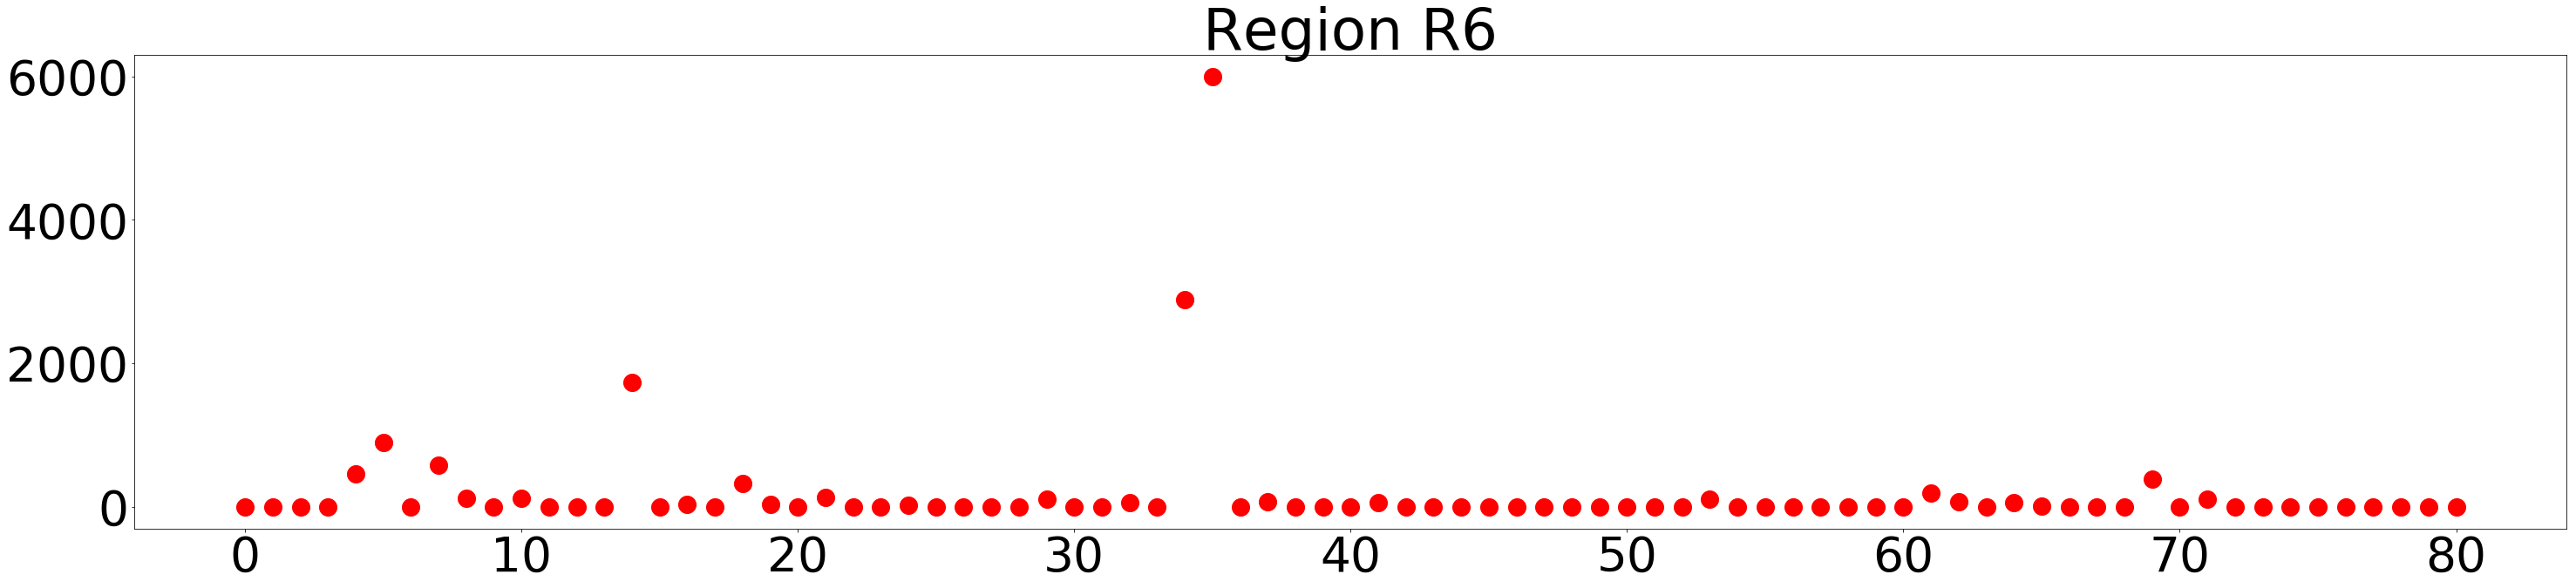

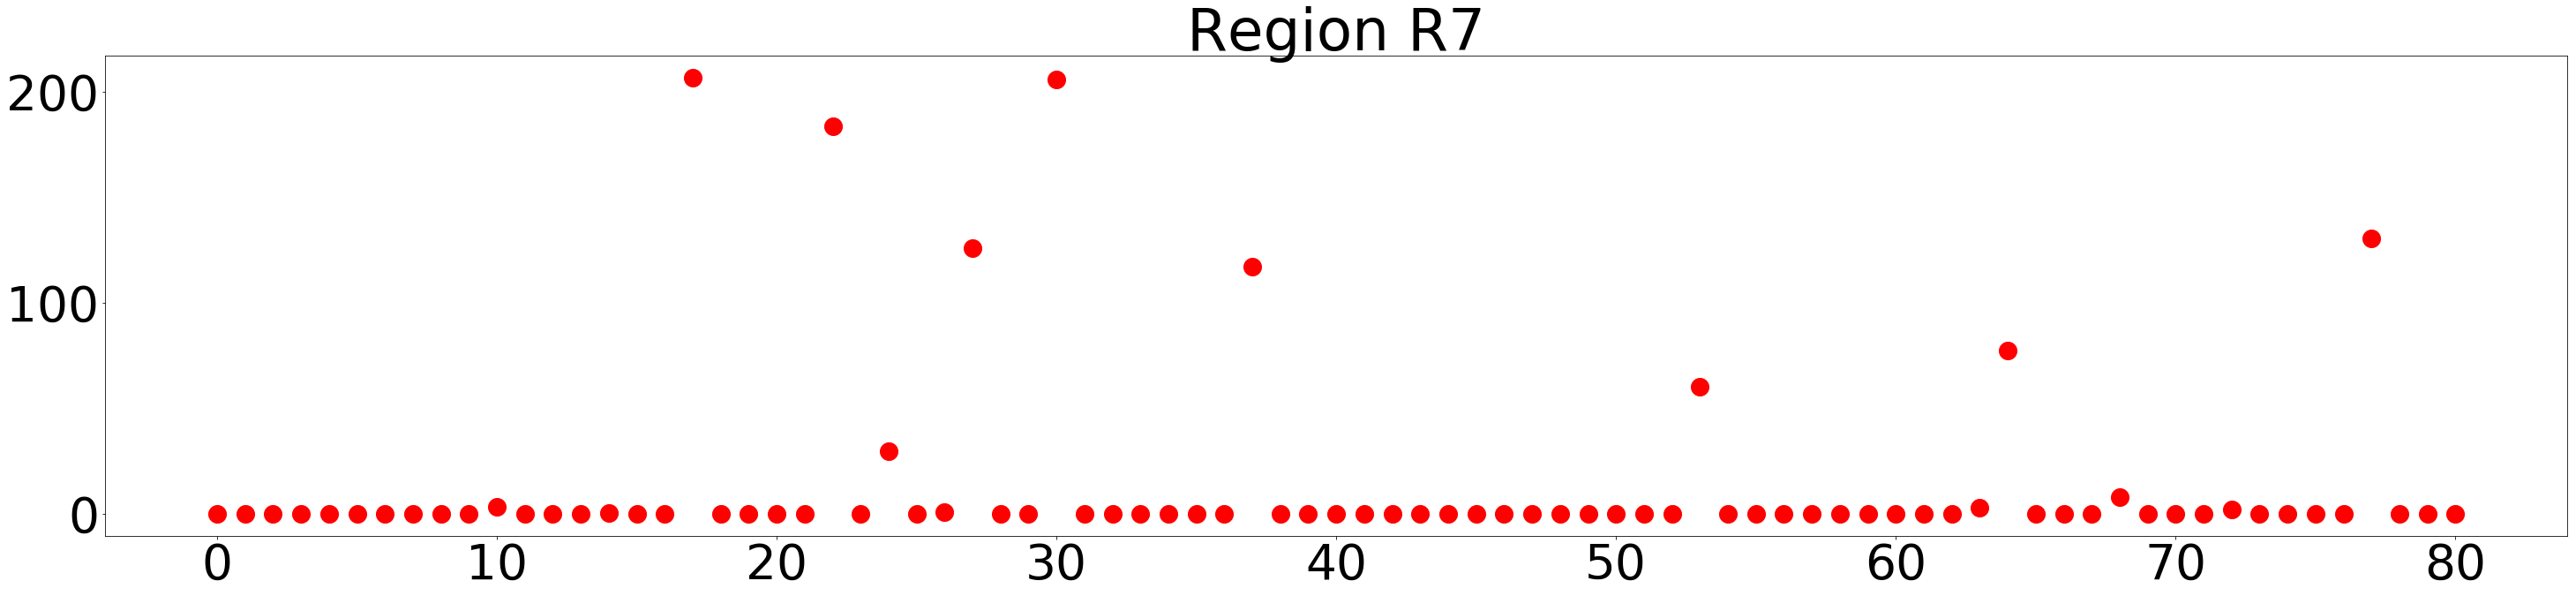

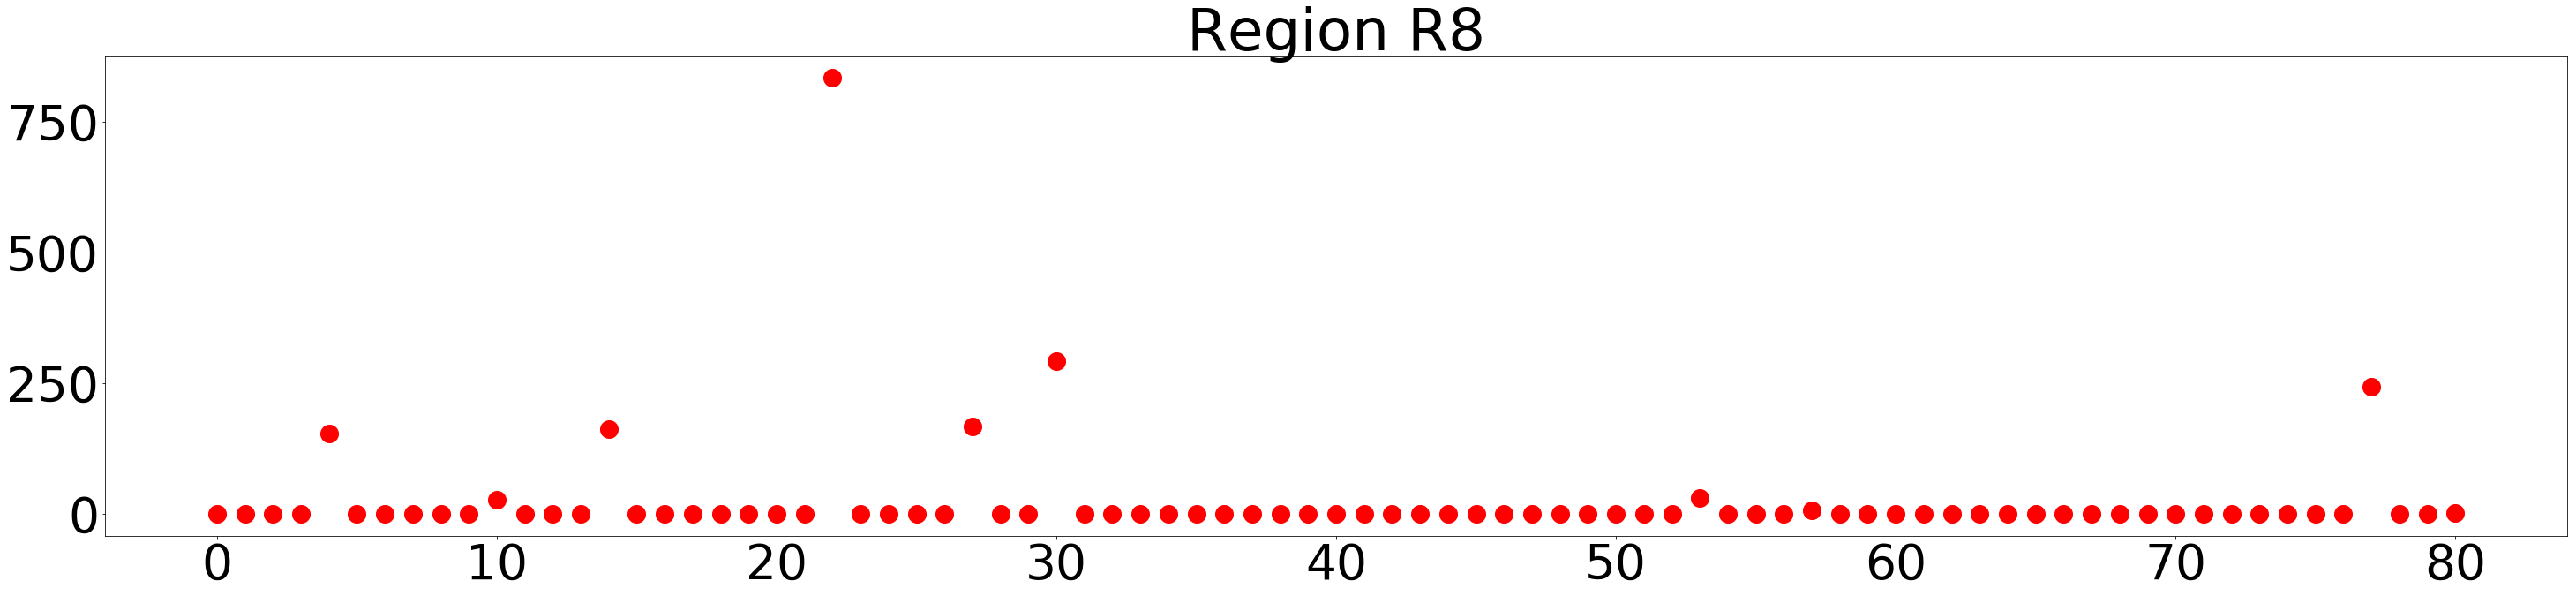

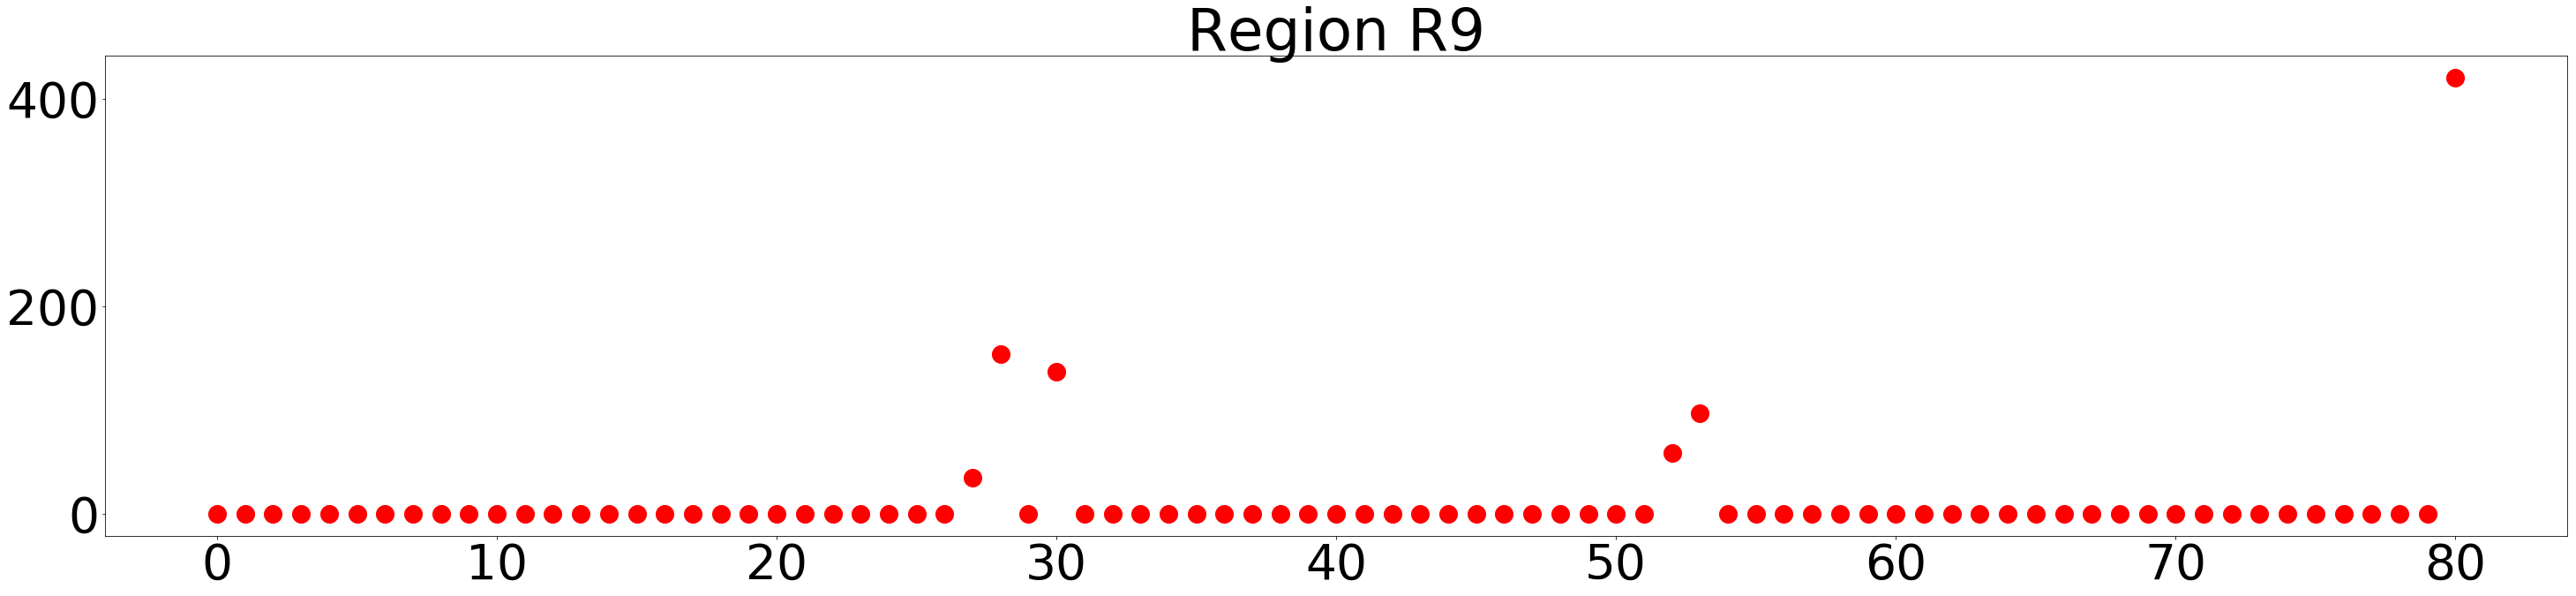

['R1' 'R10' 'R11' 'R12' 'R13' 'R14' 'R15' 'R16' 'R17' 'R18' 'R2' 'R3' 'R4'
 'R5' 'R6' 'R7' 'R8' 'R9']


In [7]:
#product demand region wise
regions
indices
for i in range(len(regions)):
    prod_freq = [0] * len(products)
    indices = list(range(len(products)))
    for j in range(len(products)):
        freq = predicted_demand.loc[(predicted_demand['Region'] == regions[i]) & (predicted_demand['Product_ID'] == products[j])]
        prod_freq[j] = freq['Demand'].sum()
#         if prod_freq[j] > 0:
#             print(products[j]," ",prod_freq[i])
    plt.figure(figsize=(50,10))
    plt.rc('font', size=55)
    plt.plot(indices , prod_freq, 'ro', markersize=20)
    plt.title("Region "+regions[i])
    plt.show()
    
print(regions)
# plt.figure(figsize=(10,10))
# plt.rc('font', size=15)
# print(predicted_demand.loc[(predicted_demand['Product_ID'].isin(products[:10]))])
# plt.hist(predicted_demand.loc[(predicted_demand['Product_ID'].isin(products[:10]))]['Product_ID'])
# width = indices[1] - indices[0]
# plt.plot(indices , prod_freq, 'ro', markersize=2)
# plt.show()

In [16]:
for i in range(len(products)):
    freq = predicted_demand.loc[(predicted_demand['Product_ID'] == products[i])]
    prod_freq[i] = freq['Demand'].sum()

sorted_freq = sorted(prod_freq)
print([products[prod_freq.index(freq)] for freq in sorted_freq][-10:])
products[prod_freq.index(max(prod_freq))]

['P8', 'P43', 'P22', 'P15', 'P40', 'P35', 'P9', 'P23', 'P41', 'P4']


'P4'

In [9]:
print([products[prod_freq.index(freq)] for freq in sorted_freq][-10:])
print([freq for freq in sorted_freq][-10:])

['P8', 'P43', 'P22', 'P15', 'P40', 'P35', 'P9', 'P23', 'P41', 'P4']
[2027.7081893942448, 2169.0946361428023, 2491.732816747916, 2620.0356811204883, 2886.8797384951818, 2916.003601018749, 3789.2051952074416, 4020.3034633442203, 5995.236360127796, 22067.43748799638]


- Find the top most demanding product.

In [34]:
predicted_demand.loc[(predicted_demand['Product_ID'] == 'P4') \
                     & (predicted_demand['Demand'] > 0)]['Region'].iloc[0]
#(predicted_demand.loc[(predicted_demand['Product_ID'] == 'P4') \
#                    & (predicted_demand['Demand'] > 0)]['Region'].tolist())

['R11', 'R11', 'R11']

- Get where the demand is

In [11]:
delivery_cost.loc[(delivery_cost['Region'] == 'R11')]

,Plant,Region,Delivery_cost
10,A,R11,148.041475
28,B,R11,233.000000
46,C,R11,213.722138


- Get delivery cost for demanding region/s. Find min cost.

In [12]:
production_capacity.loc[(production_capacity['Plant'] == 'B') & (production_capacity['Product'] == 'P4')]

,Plant,Line,Product,Capacity
165,B,1,P4,326
246,B,2,P4,343
327,B,3,P4,333


- Now we have capacity of the plant, line wise. So we can start scheduling of 'P4' on plant B.
- Here we can get a plant which doesn't make the product we are looking for. So we'll have to look for other plant here

In [13]:
print("demand of the month 37")
p4_demand = predicted_demand.loc[
    (predicted_demand['Product_ID'] == 'P4') & (predicted_demand['Demand'] > 0) & (predicted_demand['Month'] == 37)]['Demand']
print(p4_demand)
print('min days this plant can take',(p4_demand/(326+343+333)))

demand of the month 37
1788    7355.812496
Name: Demand, dtype: float64
min days this plant can take 1788    7.34113
Name: Demand, dtype: float64


- We'll go month wise. We'll read 37th month's demand. And then we'll see if we can accomodate it in this plant in max 14 days or not.

In [14]:
print("Schedule the lines for ", round(p4_demand/(326+343+333)))

Shedule the lines for  1788    7.0
Name: Demand, dtype: float64


- If days we can complete it in this plant in max 14 days then schedule the plant's line for round about days.